# Predict Movie Genre and Rating in Test/Train Data

Using the k-nearest neighbors method, use the top-k most similar movies to a target film to predict the target movie's genre and rating.

Use Jaccard similarity based on actors in each movie to rank movies and select the top-k most similar movies.

In [3]:
import json

import pandas as pd
import numpy as np

from scipy.sparse import lil_matrix

import matplotlib.pyplot as plt


In [4]:
actor_name_map = {}
movie_actor_map = {}
actor_genre_map = {}


with open("movies.json", "r") as in_file:
    for line in in_file:
        
        # Read the movie on this line and parse its json
        this_movie = json.loads(line)
        
        # Skip movies with no ratings
        if len(this_movie["rating"]) == 0:
            continue
                    
        # Add all actors to the id->name map
        for actor_id,actor_name in this_movie['actors']:
            actor_name_map[actor_id] = actor_name
            
        # For each actor, add this movie's genres to that actor's list
        for actor_id,actor_name in this_movie['actors']:
            this_actors_genres = actor_genre_map.get(actor_id, {})
            
            # Increment the count of genres for this actor
            for g in this_movie["genres"]:
                this_actors_genres[g] = this_actors_genres.get(g, 0) + 1
                
            # Update the map
            actor_genre_map[actor_id] = this_actors_genres
            
        # Finished with this film
        movie_actor_map[this_movie["imdb_id"]] = ({
            "movie": this_movie["title"],
            "actors": set([item[0] for item in this_movie['actors']]),
            "genres": this_movie["genres"],
            "rating": this_movie["rating"]["avg"]
        })

In [5]:
print("Known Actors:", len(actor_name_map))
print("Known Movies:", len(movie_actor_map))

Known Actors: 29499
Known Movies: 18841


In [6]:
actor_id_to_index = {actor_id:i for i,actor_id in enumerate(actor_name_map.keys())}


## Split Data into Training/Testing Data

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
all_movie_ids = np.array(list(movie_actor_map.keys()))
training_ids, testing_ids = train_test_split(all_movie_ids, test_size=0.1)

In [9]:
training_ids.shape, testing_ids.shape

((16956,), (1885,))

## For Each Movie in Test Set, Use Jaccard Similarity by Actor to Predict Genre and Rating

For each movie in the test set, we find the k most similar movies **in the training set** to predict the test movie's genre and its rating.

Then compare the predictions to the actual data from the `movie_actor_map` to calculate accuracy of this prediction.

In [10]:
k_nn = range(2,21)

In [11]:
prediction_rows = {
    k:[] for k in k_nn
}

for test_movie_id in testing_ids:

    # This test movie
    target_movie_object = movie_actor_map[test_movie_id]
    
    # List of similar movies
    test_movie_similarities = []

    # Iterate through every movie in the training set
    for this_movie_id in training_ids:
            
        if this_movie_id == test_movie_id:
            continue
                    
        this_movie_actors = set(movie_actor_map[this_movie_id]['actors'])
        test_movie_actors = set(target_movie_object['actors'])
        
        
        intersection = len(this_movie_actors.intersection(test_movie_actors))
        union = len(this_movie_actors.union(test_movie_actors))
        
        if union == 0:
            similarity = 0
        else:
            similarity = intersection/union
                    
        test_movie_similarities.append({
        "movie": this_movie_id,
        "jaccard": similarity,
        })

    
    similarity_df = pd.DataFrame(test_movie_similarities, columns=["movie", "jaccard"])
    
    for k in k_nn:
        # Get the top k movies
        top_movies = similarity_df.sort_values(by="jaccard", ascending=False).head(k)
            
        # iterate through the top k movies and predict genre and rating
        relevant_ratings = []
        relevant_genre_count = {}
        for this_movie_id in top_movies["movie"]:
            # add relevant ratings
            relevant_ratings.append(movie_actor_map[this_movie_id]['rating'])
            
            # Track genres
            for genre in movie_actor_map[this_movie_id]['genres']:
                if genre in relevant_genre_count:
                    relevant_genre_count[genre] += 1
                else:
                    relevant_genre_count[genre] = 1
                        
                
        # Get the most common genre from the neighbors
        predicted_genre = max(relevant_genre_count, key = relevant_genre_count.get)

        # Take the average rating of k neighbors for prediction
        predicted_rating = sum(relevant_ratings) / len(relevant_ratings)

        # Track predictions
        prediction_rows[k].append({
            "imdb_id": test_movie_id,
            "genre": predicted_genre,
            "rating": predicted_rating,
        })



In [14]:
predicted_df = {
    k: pd.DataFrame(rows).set_index("imdb_id") for k, rows in prediction_rows.items()
}
predicted_df

{2:                   genre  rating
 imdb_id                        
 tt4923846         Drama    5.25
 tt15097216       Action    5.45
 tt0416688      Thriller    5.70
 tt1470910         Drama    5.20
 tt5266456        Action    8.45
 ...                 ...     ...
 tt6604334   Documentary    7.55
 tt1272492        Comedy    5.45
 tt2429640         Drama    6.95
 tt6560320         Drama    7.00
 tt13374182      History    4.55
 
 [1885 rows x 2 columns],
 3:                   genre    rating
 imdb_id                          
 tt4923846         Drama  5.566667
 tt15097216       Action  6.400000
 tt0416688      Thriller  5.000000
 tt1470910         Drama  5.533333
 tt5266456         Drama  7.200000
 ...                 ...       ...
 tt6604334   Documentary  6.966667
 tt1272492        Comedy  5.133333
 tt2429640         Drama  6.966667
 tt6560320         Drama  5.666667
 tt13374182      History  4.100000
 
 [1885 rows x 2 columns],
 4:                   genre  rating
 imdb_id          

## Measure Accuracy of Predictions

In [17]:
correct_dict = {}

for k, df in predicted_df.items():
    
    correct_genres = []
    for movie_id,row in df.iterrows():
        
        if row['genre'] in movie_actor_map[movie_id]['genres']:
            correct_genres.append(1)
        else:
            correct_genres.append(0)   
            
    accuracy = sum(correct_genres) / len(correct_genres)
    print("Genre Accuracy:", accuracy)
    correct_dict[k] = accuracy
    

Genre Accuracy: 0.4153846153846154
Genre Accuracy: 0.4572944297082228
Genre Accuracy: 0.48488063660477454
Genre Accuracy: 0.519893899204244
Genre Accuracy: 0.5336870026525199
Genre Accuracy: 0.5527851458885942
Genre Accuracy: 0.5623342175066313
Genre Accuracy: 0.5671087533156499
Genre Accuracy: 0.5750663129973475
Genre Accuracy: 0.5851458885941645
Genre Accuracy: 0.5893899204244032
Genre Accuracy: 0.5877984084880636
Genre Accuracy: 0.5946949602122016
Genre Accuracy: 0.5877984084880636
Genre Accuracy: 0.5877984084880636
Genre Accuracy: 0.5877984084880636
Genre Accuracy: 0.589920424403183
Genre Accuracy: 0.5925729442970822
Genre Accuracy: 0.5957559681697613


In [19]:
rating_dict = {}

for k, df in predicted_df.items():

    rating_mses = []

    for movie_id,row in df.iterrows():
        rating_mses.append((row['rating']-movie_actor_map[movie_id]['rating'])**2)
        
    mse = sum(rating_mses) / len(rating_mses)
    print("Rating Mean Squared Error:", mse)
    rating_dict[k] = mse

Rating Mean Squared Error: 2.2939336870026548
Rating Mean Squared Error: 1.987331564986741
Rating Mean Squared Error: 1.8518295755968188
Rating Mean Squared Error: 1.752980159151189
Rating Mean Squared Error: 1.6968283230179804
Rating Mean Squared Error: 1.6510185676392566
Rating Mean Squared Error: 1.6217636770557056
Rating Mean Squared Error: 1.5936256999705272
Rating Mean Squared Error: 1.5864767639257324
Rating Mean Squared Error: 1.5697066444527223
Rating Mean Squared Error: 1.555806145004421
Rating Mean Squared Error: 1.538763894338677
Rating Mean Squared Error: 1.5266805878850198
Rating Mean Squared Error: 1.5209305039787795
Rating Mean Squared Error: 1.5125448234416468
Rating Mean Squared Error: 1.5036629739428906
Rating Mean Squared Error: 1.4964275796574624
Rating Mean Squared Error: 1.5051442574046494
Rating Mean Squared Error: 1.5042449469496042


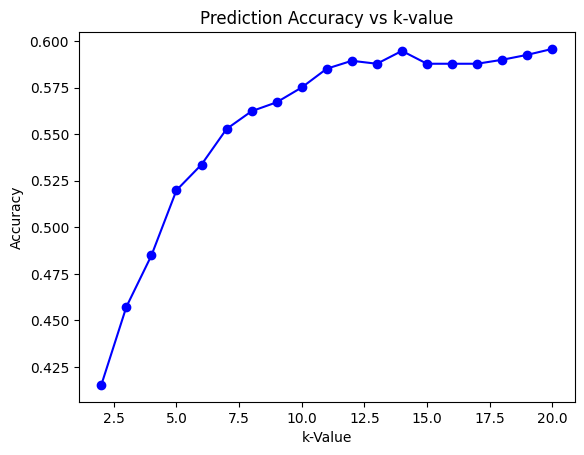

In [22]:
# correct_dict graph

keys = list(correct_dict.keys())
values = list(correct_dict.values())

plt.plot(keys, values, marker='o', linestyle='-', color='b')

plt.xlabel('k-Value')
plt.ylabel('Accuracy')
plt.title('Prediction Accuracy vs k-value')

plt.show()


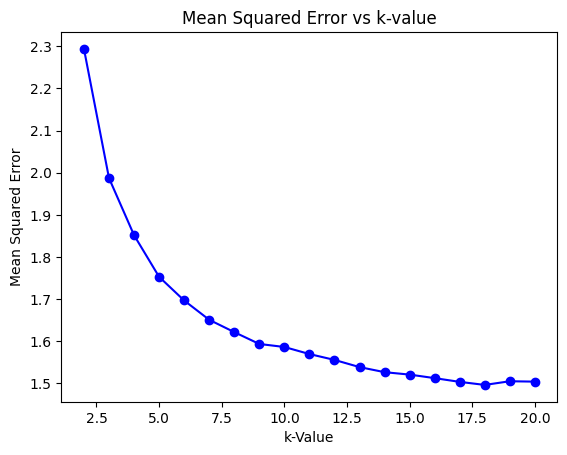

In [23]:
# rating_dict graph

keys = list(rating_dict.keys())
values = list(rating_dict.values())

plt.plot(keys, values, marker='o', linestyle='-', color='b')

plt.xlabel('k-Value')
plt.ylabel('Mean Squared Error')
plt.title('Mean Squared Error vs k-value')

plt.show()